In [1]:
import os
import shutil
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from lang_sam import LangSAM
import numpy as np
from PIL import Image
import cv2
from matplotlib.lines import Line2D

https://github.com/luca-medeiros/lang-segment-anything


In [2]:
model = LangSAM()

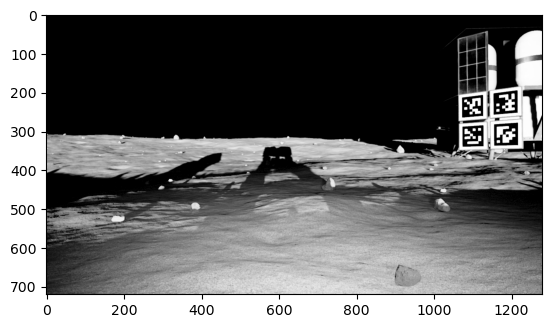

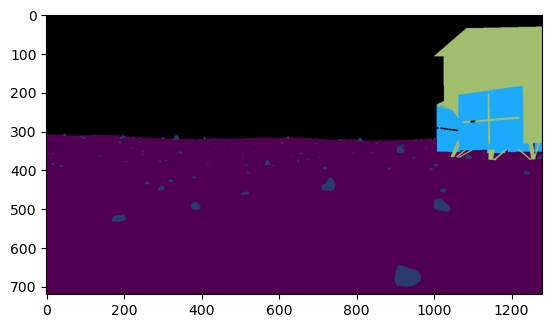

In [151]:
base_path = Path("/home/shared")
scene = "data_collection_1"
camera = "front_left"
scene_path = base_path / "data_raw" / "LAC" / scene
images_rgb_path = scene_path / "front_left"
images_sem_path = scene_path / "front_left_semantic"
image_rgb_path = images_rgb_path / "34.png"
image_sem_path = images_sem_path / "34.png"
image_rgb = cv2.imread(image_rgb_path.as_posix())
image_sem = cv2.imread(image_sem_path.as_posix())
plt.imshow(image_rgb)
plt.show()
plt.imshow(image_sem)
plt.show()

array([[  0,   0,   0],
       [ 30, 170, 250],
       [ 42,  59, 108],
       [ 81,   0,  81],
       [160, 190, 110]], dtype=uint8)


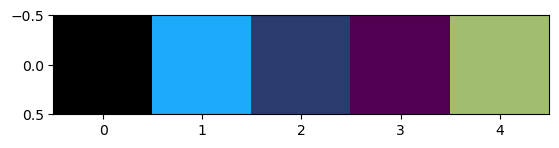

In [152]:
colors_unique = np.unique(np.vstack(image_sem), axis=0)
print(repr(colors_unique))
plt.imshow([colors_unique / 255.0])

In [153]:
semantic_data = [
    ("Fiducials", "fiducials", np.array([30, 170, 250])),
    ("Rocks", "rocks", np.array([42, 59, 108])),
    ("Lander", "white vehicle", np.array([160, 190, 110])),
    ("Shadow", "dark shadow", np.array([150, 40, 60])),
    ("Sun", "sun", np.array([255, 255, 0])),
    ("Ground", "ground", np.array([81, 0, 81])),
    ("Sky", "sky", np.array([0, 0, 0])),
    ("Unknown", "unknown", np.array([255, 255, 255])),
]
prompt2color = {prompt: color for _, prompt, color in semantic_data}
prompt2label = {prompt: label for label, prompt, _ in semantic_data}

In [154]:
prompt = ".".join([prompt for label, prompt, color in semantic_data])
image_pil = Image.fromarray(image_rgb.copy())
results = model.predict([image_pil], [prompt])
res = results[0]
print(res["labels"])

['ground', 'sky', 'rocks', 'rocks', 'dark shadow', 'rocks', 'rocks', 'white vehicle', 'rocks', 'rocks', 'fiducials']


In [155]:
[prompt for prompt in res["labels"]]

['ground',
 'sky',
 'rocks',
 'rocks',
 'dark shadow',
 'rocks',
 'rocks',
 'white vehicle',
 'rocks',
 'rocks',
 'fiducials']

In [156]:
res_dict

{'fiducials': [],
 'rocks': [array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)],
 'white vehicle': [],
 'dark shadow': [array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
  

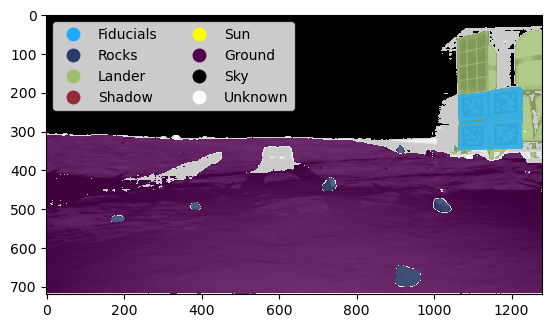

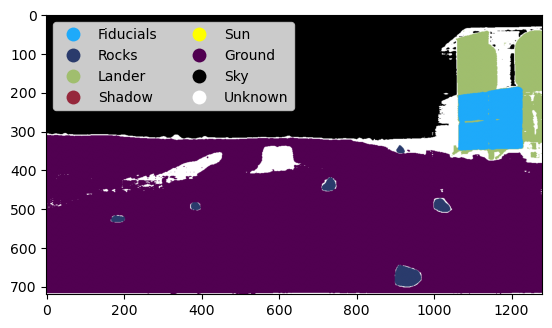

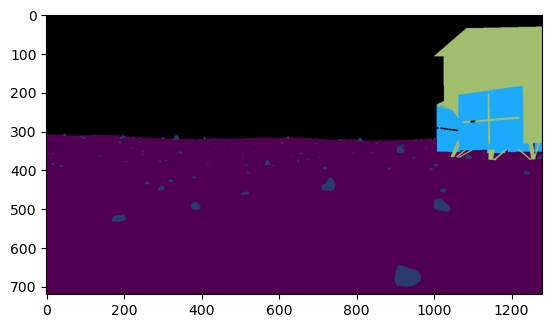

In [157]:
plt.imshow(image_pil)

image_proc = np.ones_like(image_rgb) * prompt2color["unknown"] / 255

unknown_mask = np.zeros(image_rgb.shape[:2], dtype=float)
res_dict = {
    prompt: [res["masks"][i] for i in range(len(res["labels"])) if res["labels"][i] == prompt]
    for prompt in prompt2color.keys()
}

for label, prompt, color in semantic_data[::-1]:
    if label == "Shadow":
        continue
    for mask in res_dict[prompt]:
        mask_rgb = np.zeros((*mask.shape, 4))  # RGBA format
        mask_rgb[..., :3] = color / 255  # Assign RGB color
        mask_rgb[..., 3] = mask * 0.8  # Alpha channel (transparency)
        image_proc[mask.astype(bool)] = color / 255
        unknown_mask += mask
        plt.imshow(mask_rgb, interpolation="none")

unknown_rgb = np.zeros((*image_rgb.shape[:2], 4))  # RGBA format
unknown_rgb[..., :3] = prompt2color["unknown"] / 255  # Assign RGB color
unknown_rgb[..., 3] = (unknown_mask == 0) * 0.8
plt.imshow(unknown_rgb, interpolation="none")

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        label=label,
        markerfacecolor=color / 255,
        markersize=10,
        linestyle="None",
        markeredgewidth=0,
    )
    for label, _, color in semantic_data
]


plt.legend(handles=legend_elements, loc="upper left", ncol=2)
plt.show()

plt.imshow(image_proc)
plt.legend(handles=legend_elements, loc="upper left", ncol=2)
plt.show()

plt.imshow(image_sem)
plt.show()

In [158]:
np.unique(image_proc.reshape(-1, image_proc.shape[2]), axis=0) * 255

array([[  0.,   0.,   0.],
       [ 30., 170., 250.],
       [ 42.,  59., 108.],
       [ 81.,   0.,  81.],
       [160., 190., 110.],
       [255., 255., 255.]])

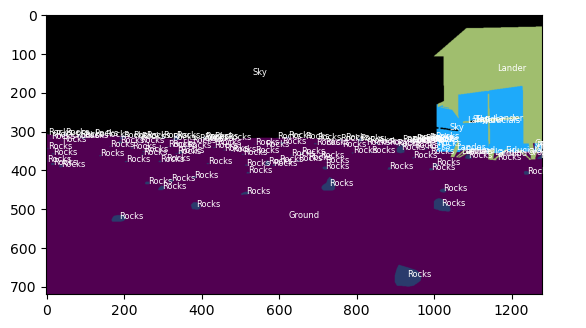

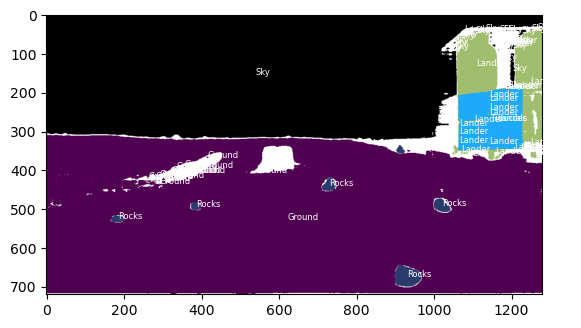

In [159]:
from scipy import ndimage


def plot_semantic_labels(image):
    plt.imshow(image)

    unique_colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)

    # Process each unique color
    for label, _, color in semantic_data:
        # Create a binary mask for the current color
        mask = np.all(image == color, axis=-1).astype(np.uint8)
        mask |= np.all(image * 255 == color, axis=-1).astype(np.uint8)

        # Find connected components
        labeled_array, num_features = ndimage.label(mask)

        # Compute centroids of the connected components
        centroids = ndimage.center_of_mass(mask, labeled_array, range(1, num_features + 1))

        # Plot centroids and label them with the color
        if label not in ("Unknown"):
            for centroid in centroids:
                y, x = int(centroid[0]), int(centroid[1])  # Convert to integer
                plt.text(
                    x,
                    y,
                    label,
                    color="white",
                    fontsize=6,
                    bbox=dict(facecolor="black", edgecolor="none", alpha=0),
                )

    # Show the result
    plt.show()


plot_semantic_labels(image_sem)
plot_semantic_labels(image_proc)